
<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">EM Connectomics - Question 2</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">XXX, August XX, XXXX</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p><b>Task 1:</b> This question looks at the mapping what fraction of synapses map to cells inhibitory or excitatory cells.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b> Import the key modules and set parameters

</div>

In [1]:
from caveclient import CAVEclient
from meshparty import trimesh_io, trimesh_vtk
import pandas as pd
import numpy as np
client = CAVEclient('minnie65_public_v117')


In [2]:
syn_table_resolution = client.materialize.get_table_metadata(client.materialize.synapse_table)['voxel_resolution']

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Task 1.2:</b> Pick a neuron with a clean or extended axon
      </div>

In [3]:
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

In [7]:
cln_df=client.materialize.query_table('proofreading_status_public_release', 
                              filter_in_dict={'status_axon': ['clean', 'extended']})



In [8]:
cln_df

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,346,t,89660913577302088,864691136194248918,864691136194248918,extended,extended,"[181147, 143788, 22167]"
1,347,t,89941288908184714,864691135517422218,864691135517422218,extended,extended,"[182993, 135610, 21130]"
2,348,t,85369450370657325,864691135753932237,864691135753932237,extended,extended,"[149711, 151738, 17565]"
3,349,t,92129866602123648,864691135367058169,864691135367058169,extended,extended,"[198949, 188854, 19772]"
4,350,t,88815663879226337,864691135293126156,864691135293126156,extended,extended,"[174921, 137614, 21123]"
...,...,...,...,...,...,...,...,...
244,597,t,89387616151457371,864691135472222258,864691135472222258,clean,clean,"[178752, 204992, 21876]"
245,598,t,90867283790442087,864691136273892365,864691136273892365,clean,clean,"[189888, 219168, 20920]"
246,599,t,89249352362824046,864691135293200652,864691135293200652,clean,clean,"[178160, 223344, 20216]"
247,600,t,88686746275324078,864691135809729740,864691135809729740,clean,clean,"[174032, 225648, 22347]"


In [9]:
neuron_id = 864691135293126156


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Task 2.3: </b> Which of the synapses from this cell map to IDs which have just one neuron nucleus?
        </div>

In [11]:
# get all the synapses from this cell
out_df = client.materialize.synapse_query(pre_ids=neuron_id)
out_df.shape

(1308, 10)

In [13]:
# get all the neurons
nrn_df = client.materialize.query_table('nucleus_neuron_svm',
                                        filter_equal_dict={'cell_type':'neuron'})

In [16]:
# How many times does a root id appears in the table.
# Since each row is a nucleus, this effectively counts the number of neuronal somata.

soma_count_df = (
    nrn_df
        .query('cell_type == "neuron"')
        .groupby('pt_root_id')
        .count()
        .rename(columns={'valid': 'num_soma'})
    )[['num_soma']]

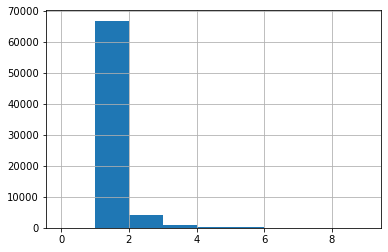

In [22]:
# make a histogram of the number of soma
# use bins 0,1,2,3,4,5,6,7,8,9,10

soma_count_df.num_soma.hist(bins=np.arange(0,10))

In [25]:
# merge this with the synapses with the neuron table
# hint use how='left' to keep all the synapses but drop unused nuclei
pre_syn_df_cnt = out_df.merge(
    soma_count_df,
    left_on='post_pt_root_id',
    right_index=True,
    how='left',
).fillna(0)

In [23]:
# pull out the predictions about e vs i
ei_df = client.materialize.query_table('allen_soma_ei_class_model_v1')
# remove the predictions where there is more than one soma
ei_df_single = ei_df.drop_duplicates(subset=['pt_root_id'])


In [26]:
# merge in the e/i prediction into a dataframe
target_cat_df = pre_syn_df_cnt.merge(
    ei_df_single[['pt_root_id', 'cell_type']],
    left_on='post_pt_root_id',
    right_on='pt_root_id',
    how='left',
).drop(columns='pt_root_id')


In [29]:
# write a function that takes a row of your dataframe
# and returns a string describing what you know about that synapse
# orphan: when you can't map it to a soma
# merge error: when there is more than 1 soma
# unclassified: when you there is no e/i prediction
# inhibitory: when its a single soma inhibitory
# excitatory: when its a single soma excitatory

def _categorize_targets(row):
    if row['num_soma'] == 0:
        return 'orphan'
    elif row['num_soma'] > 1:
        return 'merge error'
    elif pd.isna(row['cell_type']):
        return 'unclassified'
    else: 
        return row['cell_type']
    
# use apply (axis=1) to define a label for each synapse
target_cat_df['syn_category'] = target_cat_df.apply(_categorize_targets, axis=1)

# useful to use pd.CategoricalDtype to turn your label into a categorical variable in pandas
syn_cat_dtype=pd.CategoricalDtype(categories=['inhibitory', 'excitatory', 'merge error', 'orphan', 'unclassified'], ordered=True)
target_cat_df['syn_category'] = target_cat_df['syn_category'].astype(syn_cat_dtype)


In [32]:
# how many synapses fall into each category?
target_cat_df.groupby('syn_category').count()[['valid']].rename(columns={'valid': 'num cells'})

,num cells
syn_category,
inhibitory,268
excitatory,587
merge error,105
orphan,333
unclassified,15
